#  Convoluted Fashion
by Teppei Suzuki

## Introduction
The typical dataset to benchmark your machine laerning algorithm is the MNIST data set. More recently, Zalandor Research has publish a dataset that is know as the Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. Here, we will train a ConvNet that will classify this dataset.

## Setup
Let's first import some useful libraries and load in the fashion MNIST dataset into Panda datafame objects

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

C:\Users\tep\Anaconda3\envs\untitled1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df_train = pd.read_csv('/Users/tep/PycharmProjects/ConvolutedFashion/fashion-mnist_dataset/fashion-mnist_train.csv')
df_test = pd.read_csv('/Users/tep/PycharmProjects/ConvolutedFashion/fashion-mnist_dataset/fashion-mnist_test.csv')

## Inspection
Here are the pictures straight from zalanders github. Each class takes on three rows.

We will not apply any preprocessing on this data.

![fashion-mnist](fashion-mnist-sprite.png)
![fashion-mnist-rotating](embedding.gif)

Let's take a look at how to data is stored. On the 1st column, we have a number between 0-9 indicating which label the picture belongs to. On the 2nd to the 785th column, we have the pixel intensity values. Notice that 1 + (28 * 28) = 785. In other words, the 28 by 28 pictures are flattened out along with the additon of the label on its first column.

The same applies to the test dataset.

In [3]:
df_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


We will create some variables and hyperparameters for the neral network.

Typical convention for number of filters is to use numbers in the power of 2's. Unfortunately, my computer is not "strong enough" to handing 64-128 architeture (it crashes) hence, the weird 50-100 architecture.

In [4]:
#28 x 28 pixels
data_row, data_col = 28, 28
data_shape = (data_row, data_col)
data_size = data_row * data_col

#there are 10 different classifications
class_size = 10 

#image is gray scale
num_channels = 1

#first conv layer hyper parameters
filter_size1 = 5          
num_filters1 = 50         

#second conv layer hyper parameters
filter_size2 = 5          
num_filters2 = 100       

# fully connected layer hyperparameter
fc_size = 1024

We now define a function that takes in a vector that has a correct classification digit (0-9) and returns a one hot vectore where all the elements are 0 except the correct element(which is a one)

ex.
input = [7]
output = [0,0,0,0,0,0,0,1,0,0]

In [5]:
def oneHotVec(vec, class_size):
    size = len(vec)
    oneHotVec = np.zeros((size, class_size))
    for i in range(size):
        oneHotVec[i][vec[i]] = 1
    return oneHotVec

We now splice up the training and test data into training input and correct classification.

In [6]:
x_training_input = np.array(df_train.iloc[:, 1:])
y_training_input = np.array(df_train.iloc[:, 0])
y_training_input_onehot = oneHotVec(y_training_input, class_size)

x_test_input = np.array(df_test.iloc[:, 1:])
y_test_input = np.array(df_test.iloc[:, 0])
y_test_input_onehot = oneHotVec(y_test_input, class_size)

This function will plot random images. It's always fun and good to look at the original dataset.

In [10]:
def plotRandomImages(data, num):
    # create a list with random ints of size num in the range(55000)
    random = np.random.randint(0, len(data), size=num)
    
    # list of images
    images = []
    
    # add images to the list of images using the random ints
    # we have to reshape the array to 28x28 for correct plotting
    for i in range(num):
        index = random[i]
        images += [data[index].reshape(data_shape)]
    
    # plot the images
    plt.figure(figsize=(30,10))
    columns = 8
    
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image, cmap='binary')

Let's plot 30 random images

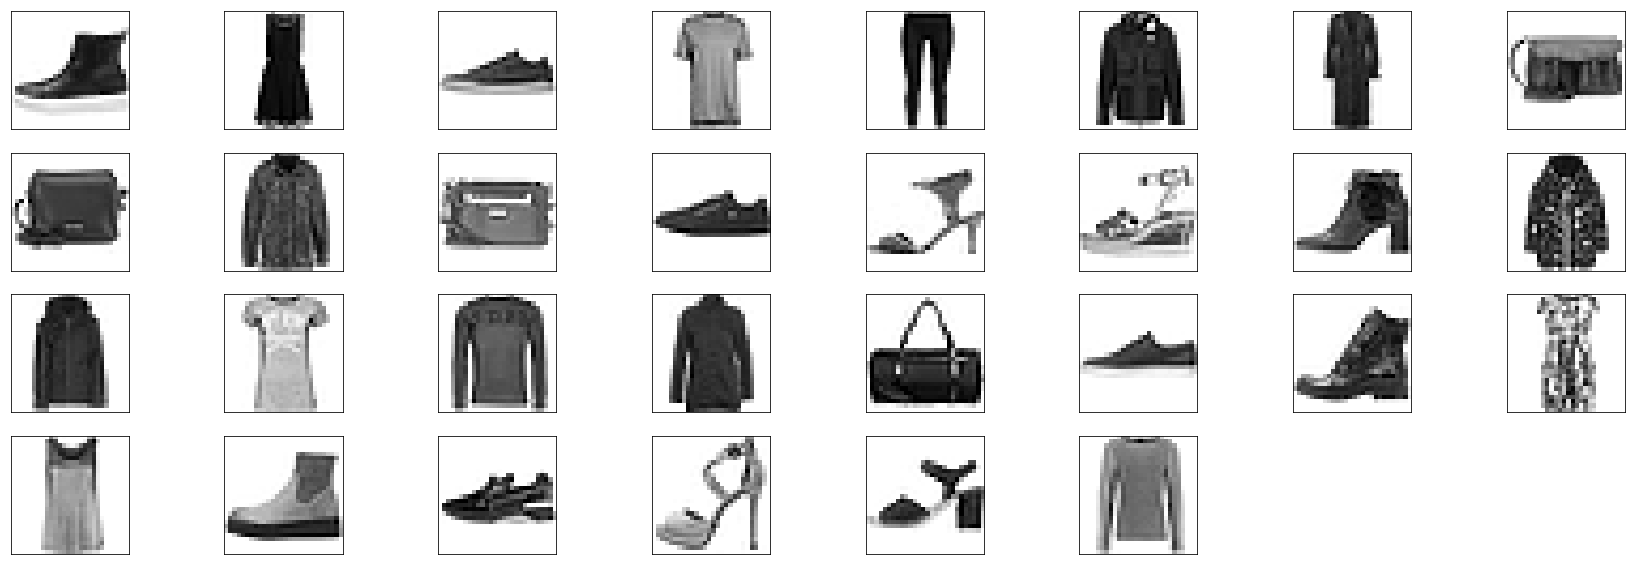

In [11]:
plotRandomImages(x_training_input, 30)

How about 30 more?

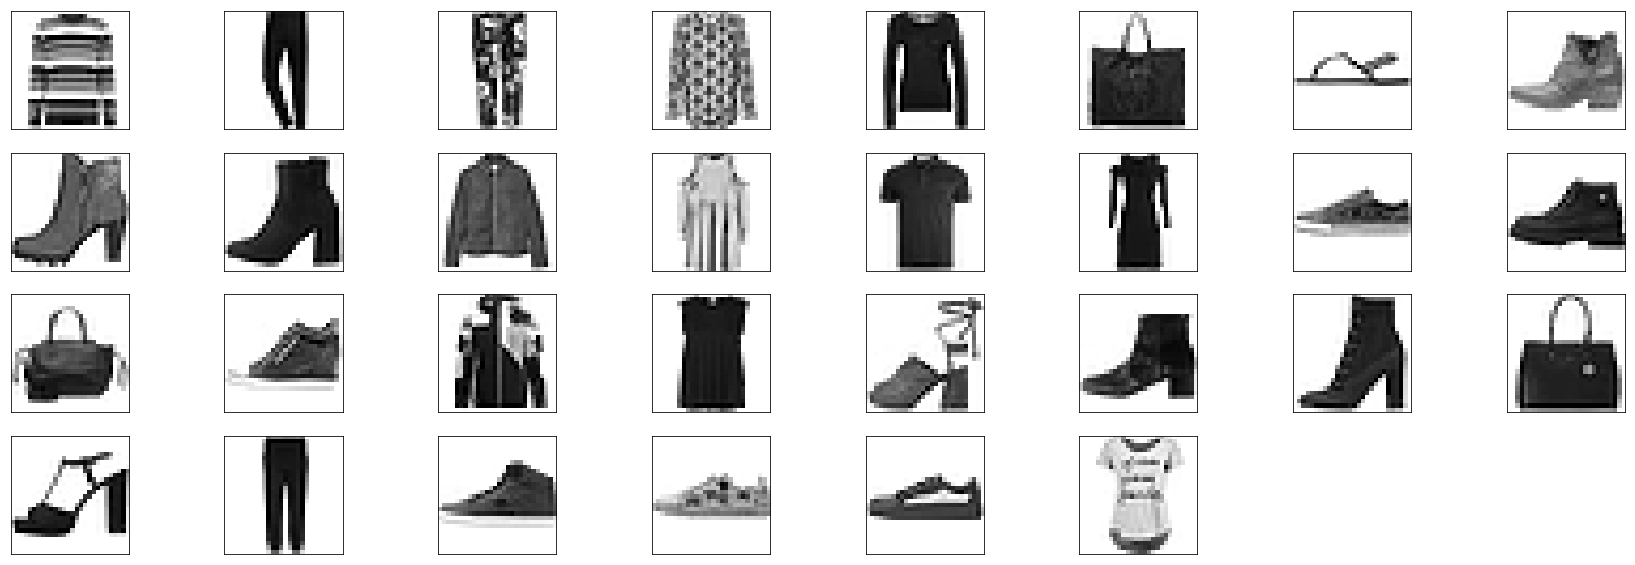

In [12]:
plotRandomImages(x_training_input, 30)

## Code
We now define some simple functions for generation of weights and bias for our neural network.

At first, I was simply generating random weight values sampled from a random normal distribution but I found out that this can often lead to suboptimal result. I have switched to a method called xavier initialization. This is a well known method and you can find plenty of resources online why this works.

In [13]:
def create_weights(shape):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape))

def create_bias(size):
    return tf.Variable(tf.zeros(shape=[size]))

We now define a function that takes in the previous layer, input channel sze, filter size of the conv layer, and number of filter of the conv layer.

In [14]:
def createConvLayer(prev_layer,              
                   num_input_channels, 
                   filter_size,        
                   num_filters):
    
    # define a organizing variable. Tensorflow api requires this format.
    shape = [filter_size, filter_size, num_input_channels, num_filters] 
    
    #create weights using our defined function from above
    weights = create_weights(shape)
    
    #create biases using our defined function from above
    biases = create_bias(num_filters)
    
    # create a conv layer using the input previous layer, our newly generated weights.
    # we use a stride of 1 and 0 pad the borders so that every neuron is sampled equal amount of times.
    layer = tf.nn.conv2d(input=prev_layer,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    
    # we the apply a max pool to size down and extract features of the conv layer.
    layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # add te bias term
    layer = layer + biases
    
    # we introduce some more non lineararity. Another valid choice is the leaky relu
    layer = tf.nn.relu(layer)
    
    #return the layer for furthur construction and return the weights for possible inspection of what features it is learning.
    return layer, weights

Create a placeholder for the input and correct classifications.

In [15]:
x = tf.placeholder(tf.float32, shape=[None, data_size], name='x')
x_image = tf.reshape(x, [-1, data_row, data_col, num_channels])

In [16]:
y_int = tf.placeholder(tf.int64, [None])
y_one_hot = tf.placeholder(tf.float32, [None, class_size])

We will now create the conv layers. Note that no computations are occuring during construction; it occures during training process which we will do later.

In [17]:
layer_conv1, weights_conv1 = \
    createConvLayer(x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1)

In [18]:
layer_conv2, weights_conv2 = \
    createConvLayer(layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2)

Once we created our 2 conv layers, we will flatten our output from the 2nd layer and turn it into a fully connected layer.

In [19]:
#get the shape
layer_2_shape = layer_conv2.shape

# compute the number of parameters
num_features = layer_2_shape[1:4].num_elements()

# reshape the 2nd layer
flat_conv_layer =  tf.reshape(layer_conv2, [-1, num_features])


This function creates a fully connected layer.

In [20]:
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,
                 use_relu=True): 
    # shape variable
    shape=[num_inputs, num_outputs]
    
    # create weights using our function
    weights = create_weights(shape)
    
    #create biases from sing our funtion
    biases = create_bias(num_outputs)

    # Y= Wx + b
    layer = tf.matmul(input, weights) + biases    
    
    # We are given the option to add a non lienar term.
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

We now create 2 fully connected layers. the 2nd fully connected layer out 10 outputs.

In [21]:
layer_fc1 = new_fc_layer(input=flat_conv_layer,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [22]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=class_size,
                         use_relu=False)

We now conver the predicted output of the 2nd fully connected layer to normalized probablities. We also take the max arg of this to use later for measuring accuracy.

In [23]:
#convert to normalized probablilities
y_pred = tf.nn.softmax(layer_fc2)

#take the arg max 
y_pred_cls = tf.argmax(y_pred, axis=1)

# we use the softmax for our cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_one_hot)
cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



We now create an Adam Optimizer and pass in the cost node.

In [29]:
# create adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=.0005).minimize(cost)

# checks is prediction is correct
correct_prediction = tf.equal(y_pred_cls, y_int)

# take the mean over all the prediction results to get accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
def next_batch(batch_size, data, labels, onehot):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    onehot_shuffle = [onehot[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle), np.asarray(onehot_shuffle)

## Training

Set the batchsize and iter count

In [31]:
num_iterations = 5001
batch_size = 50

Let's fire up tensorflow session

In [34]:
session = tf.Session()
session.run(tf.global_variables_initializer())

We can now train our model.

After about 4000 iterations, we achieve 91% classification accuracy on the test dataset.

In [35]:
for i in range(num_iterations):
        
        if i % 200 == 0:
            feed_dict_test = {x: x_test_input,
                    y_one_hot: y_test_input_onehot,
                    y_int: y_test_input}
            acc = session.run(accuracy, feed_dict=feed_dict_test)
            print("Iteration", i, " Accuracy =", acc)
    
        
        data, labels, onehot = next_batch(batch_size, x_training_input,y_training_input, y_training_input_onehot)
        
        feed_dict_train = {x: data,
                           y_one_hot: onehot}

        session.run(optimizer, feed_dict=feed_dict_train)
        
        

Iteration 0  Accuracy = 0.0726
Iteration 200  Accuracy = 0.8238
Iteration 400  Accuracy = 0.8506
Iteration 600  Accuracy = 0.8507
Iteration 800  Accuracy = 0.8705
Iteration 1000  Accuracy = 0.8739
Iteration 1200  Accuracy = 0.8682
Iteration 1400  Accuracy = 0.8751
Iteration 1600  Accuracy = 0.8756
Iteration 1800  Accuracy = 0.8914
Iteration 2000  Accuracy = 0.8909
Iteration 2200  Accuracy = 0.8985
Iteration 2400  Accuracy = 0.8862
Iteration 2600  Accuracy = 0.8875
Iteration 2800  Accuracy = 0.8885
Iteration 3000  Accuracy = 0.8901
Iteration 3200  Accuracy = 0.8948
Iteration 3400  Accuracy = 0.9067
Iteration 3600  Accuracy = 0.904
Iteration 3800  Accuracy = 0.8994
Iteration 4000  Accuracy = 0.9114
Iteration 4200  Accuracy = 0.9006
Iteration 4400  Accuracy = 0.9078
Iteration 4600  Accuracy = 0.8929
Iteration 4800  Accuracy = 0.9053
Iteration 5000  Accuracy = 0.9064
